# Exploration14 주식 가격 예측하기

## STEP 1 : 시계열 데이터 준비 (삼성전자에 대한 주식 시세)

칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume  
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있습니다. 종가(Close)만 사용하겠습니다.

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [120]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


DataFrame인 df와 Series인 df['Temp']는 index 구조가 동일하므로 NUmpy, Pandas, Matplotlib 등 많은 라이브러리에서 호환됩니다. 하지만 그렇지 않은 경우도 간혹 발생하기 때문에 명확하게 Series 객체를 가지고 진행하겠습니다.

## STEP 2 : 전처리 수행

In [121]:
# 결측치 처리

ts[ts.isna()]

Series([], Name: Close, dtype: float64)

해당 데이터에는 결측치가 없지만 결측치가 있다면 두 가지 방법으로 처리할 수 있습니다.
* 결측치가 있는 데이터를 모두 삭제(drop)
* 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입

ex) 2와 4 사이 데이터가 NaN이라면 3으로 채워줌

Series([], Name: Close, dtype: float64)


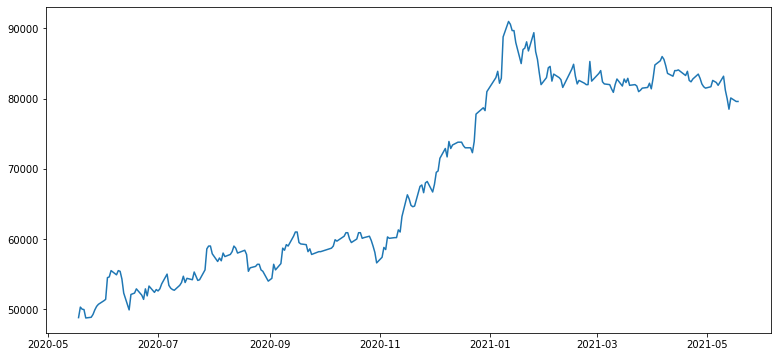

In [122]:
# 결측치가 있을 경우 보간해 줍니다. 보간 기준은 time을 선택합니다.
ts = ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

plt.plot(ts)

시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화해 보는 것이 좋습니다.

In [123]:
# 로그 변환 시도
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

### 시계열 예측 - Stationary 여부를 체크하는 통계적 방법
Augmented Dickey-Fuller Test

1. '주어진 시계열 데이터가 안정적이지 않다'라는 귀무가설(Null Hypothesis)을 세운 후  
2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에  
3. '이 시계열 데이터가 안정적이다'라는 대립가설(Alternative Hypothesis)을 채택합니다.

In [124]:
# Augmented Dickey-Fuller Test를 수행하기 위해 statsmodels패키지의 adfuller 메소드를 불러옵니다.
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

삼성전자 주가 데이터에 대한 Augmented Dickey-Fuller Test를 수행해 봅니다.

In [125]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value가 0.66 수준으로 나왔습니다. 이 정도 수준이라면 귀무가설을 채택할 수 있습니다. 따라서 '이 시계열은 안적적이다'라는 대립가설은 기각됩니다.

### 시계열 예측 - Stationary 하게 만드는 방법은?
시계열을 Stationary하게 만드는 방법은 크게 두 가지가 있습니다.
1. 정성적인 분석을 통해 보다 안정적인 특성을 가지도록 기존의 시계열 데이터를 가공/변형하는 시도  
2. 시계열 분해(Time series decomposition) 기법을 적용

1-1. Moving average 제거(추세(Trend) 상쇄하기)
시계열 분석에 있어 시간 추이에 따라 나타나는 평균값 변화를 추세(Trend)라고 합니다. 이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts에 빼주어야 합니다.

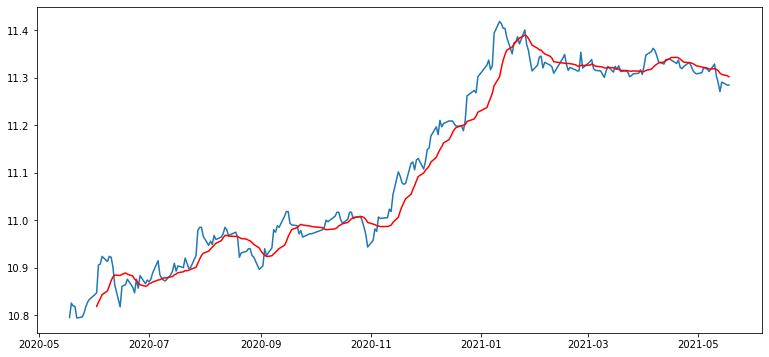

In [126]:
moving_avg = ts_log.rolling(window=12).mean() # Moving average 구하기
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [127]:
ts_moving_avg = ts_log - moving_avg # 변화량 제거
ts_moving_avg.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

windows size가 12이기 때문에 앞의 11개 데이터는 NaN(결측치)로 나타났습니다. 이들은 향후 에러를 발생시킬 수 있기 때문에 데이터셋에서 제거해줍니다.

In [128]:
ts_moving_avg.dropna(inplace=True)
ts_moving_avg.head(15)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
Name: Close, dtype: float64

시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화해 보기 위해서 함수를 만들어 줍니다.

In [129]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열
    
    # 원본시계열, 이동편균, 이동표준편차를 시각화합니다.
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

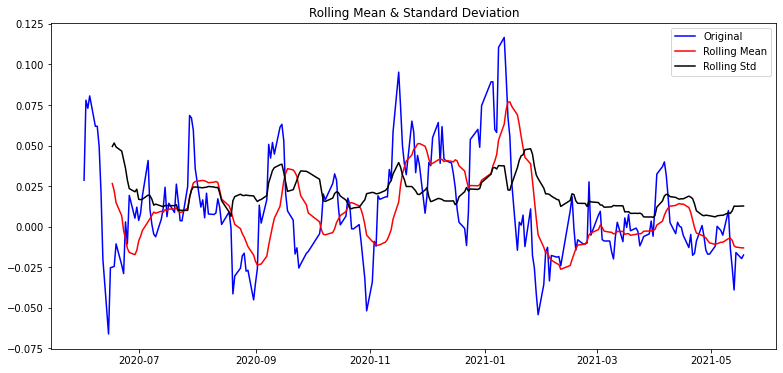

In [130]:
plot_rolling_statistics(ts_moving_avg)

In [131]:
augmented_dickey_fuller_test(ts_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


p-value가 0.001 수준이 되었습니다. window=12에서 95% 이상의 confidence로 stationary하다고 할 수 있습니다.  
window=6을 적용해 보겠습니다.

In [132]:
moving_avg_6 = ts.rolling(window=6).mean()
ts_moving_avg_6 = ts_log - moving_avg_6
ts_moving_avg_6.dropna(inplace=True)

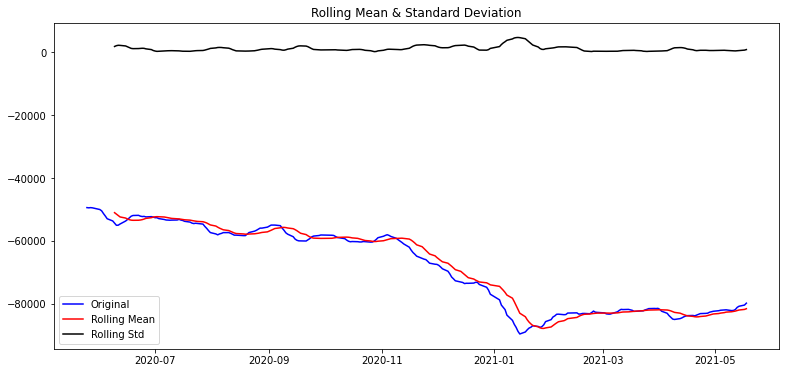

In [133]:
plot_rolling_statistics(ts_moving_avg_6)

In [134]:
augmented_dickey_fuller_test(ts_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -1.075895
p-value                          0.724588
#Lags Used                      13.000000
Number of Observations Used    231.000000
Critical Value (1%)             -3.458980
Critical Value (5%)             -2.874135
Critical Value (10%)            -2.573482
dtype: float64


p-value가 0.72 수준이 되었습니다. 따라서 주어진 timeseries는 window=12 수준에서 더욱 stationary하다고 할 수 있습니다.

1-2. 차분(Defferencing) - 계절성(Seasonality)상쇄하기  
Trend에는 잡히지 않을 수 있지만 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소입니다. 이런 계절성(Seasonality)은 Moving Average로는 상쇄되지 않습니다.  
차분(Differencing)을 통해 이를 제거할 수 있습니다. 시계열을 한 스텝 앞으로 시프트한 후 원래 시계열에 빼주는 방법입니다.  
'현재 스텝 값 - 이전 스텝 값' 공식이 돼서 정확히 '이번 스텝에서 발생한 변화량'을 의미하게 됩니다.

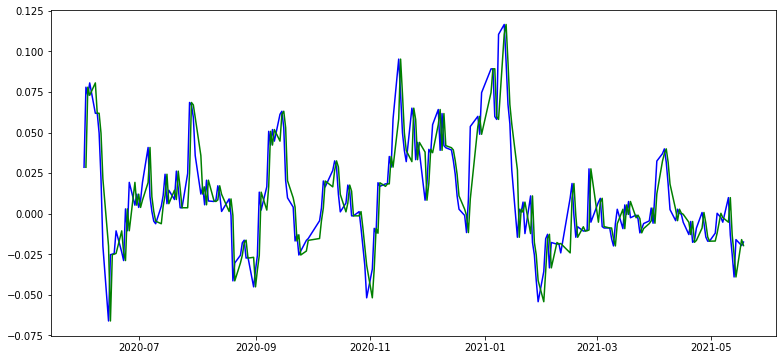

In [135]:
ts_moving_avg_shift = ts_moving_avg.shift()

plt.plot(ts_moving_avg, color='blue')
plt.plot(ts_moving_avg_shift, color='green')

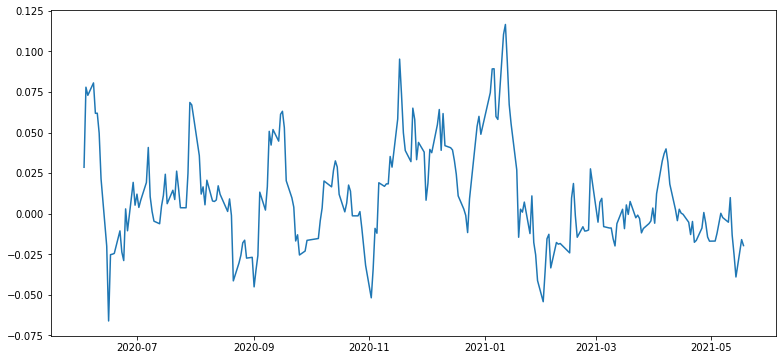

In [136]:
ts_moving_avg_diff = ts_moving_avg = ts_moving_avg_shift
ts_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_moving_avg_diff)

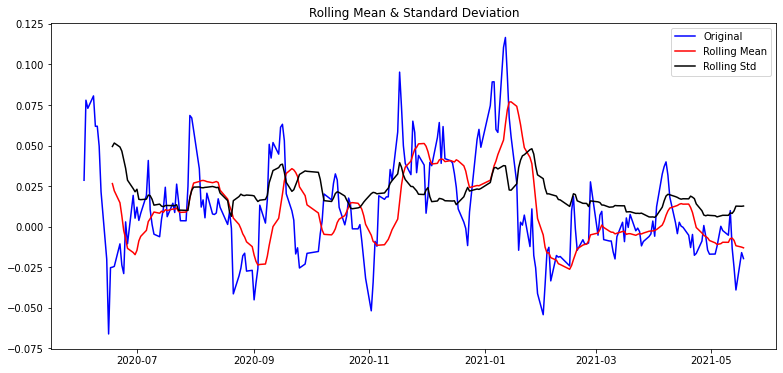

In [137]:
# 안정성 여부 확인
plot_rolling_statistics(ts_moving_avg_diff)

In [138]:
augmented_dickey_fuller_test(ts_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -4.153792
p-value                          0.000788
#Lags Used                       0.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


차분을 적용하니 p-value가 000759에서 0.000788로 소폭 증가했습니다. 2차분(2nd order differencing, 차분의 차분), 3차분(3rd order differencing, 2차 차분의 차분)을 적용할 수 있지만 충분히 낮은 p-value 값을 얻었다고 판단해 더이상 진행하지 않겠습니다.

2. 시계열 분해(Time series decomposition) 적용  
statsmodels 라이브러리 안의 seasonal_decompose 메소드는 시계열 안에 존재하는 trend, seasonality를 직접 분해할 수 있는 기능을 가지고 있습니다. 이를 활용하면 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있습니다.

In [139]:
print(type(ts_log))

<class 'pandas.core.series.Series'>


In [140]:
ts_log.head(5)

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
Name: Close, dtype: float64

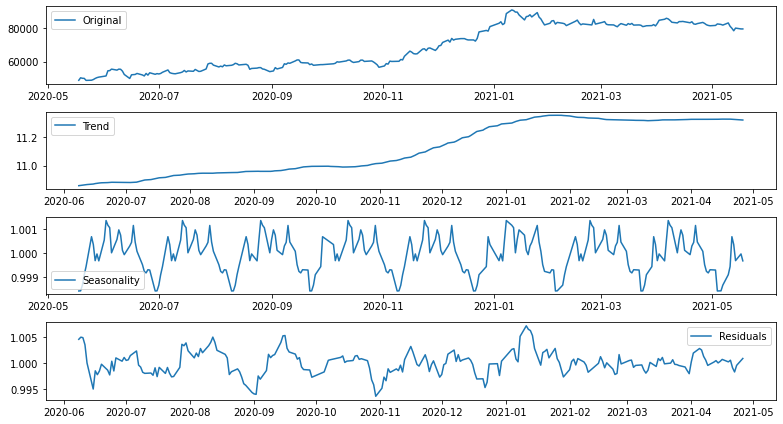

In [141]:
# 주기적 변화의 크기나 전체적인 level을 기준으로 한 variation이 일정할 때에는 additive decomposition이 적절하다. 만약 이들이 시간의 흐름에 비례하게 변화한다면 multiplicative decomposition을 고려해봐야 한다. 특히 경제 지표 관련 타임시리즈는 multiplicative model을 따르는 경우가 많다

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적인 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6) # matlab 차트의 크기를 (11,6)으로 고정해줍니다.
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지는 Residual입니다.  
뒤집어서 말하면 Trend + Seasonality + Residual = Original이 성립한다는 뜻입니다.  
이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해 줍니다.

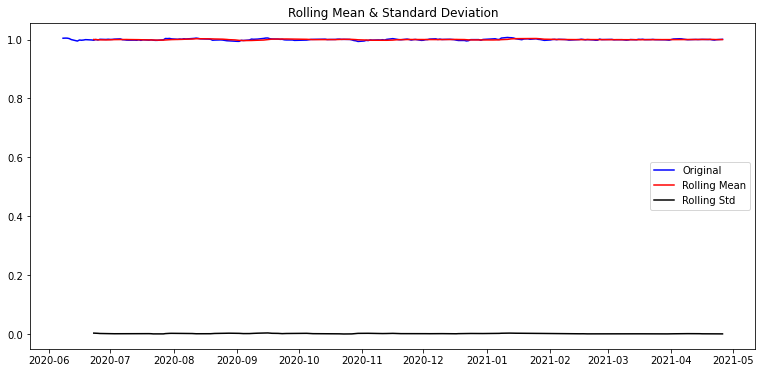

In [142]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [143]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여줍니다. 이정도면 예측 가능한 수준의 안정적인 시계열을 얻었다고 할 수 있습니다.

## STEP 4 : 학습, 테스트 데이터셋 생성

분리 비율은 학습과 테스트 9:1로 합니다. 시계열 예측이니 가장 나중 데이터를 테스트용으로 사용하는 것이 타당합니다.

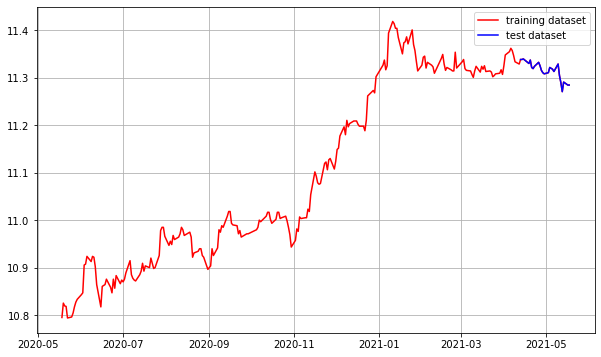

In [144]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [145]:
# 데이터셋의 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


## STEP 5 : 적정 ARIMA 모수 찾기

### Arima 모델의 개념

시계열 데이터가 Trend와 Seasonality, Residual로 분해되며  
Trend와 Seasonality를 잘 분리해 낸 경우 Residual이 예측력 있는 안정적인 시계열 데이터가 되는 것을 확인했습니다.  
ARIMA(Autoregressive Intergrated Moving Average)를 사용하면 이 원리를 이용해 시계열 데이터 예측 모델을 자동으로 만들 수 있습니다.  
ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)라고 할 수 있습니다.

1-1 AR(자기회귀, Autoregressive)
* 과거 값들에 대한 회귀로 미래 값을 예측하는 방법
* Yt가 이전 p개의 데이터의 가중합으로 수렴한다고 보는 모델

1. AR은 시계열의 Residual에 해당하는 부분을 모델링한다고 볼 수 있습니다.  
2. 가중치의 크기가 1보다 작은 가중합으로 수렴하는 자기회위모델과 안정적 시계열은 통계학적으로 동치입니다.  
3. 주식값이 항상 일정한 균형 수준을 유지할 것이라고 계측하는 관점이 바로 주식 시계열을 AR로 모델링하는 관점이라고 볼 수 있습니다.

---------------------

1-2 MA(이동평균, Moving Average)  
* MA는 Yt가 이전 q개의 예측오차값의 가중합으로 수렴한다고 보는 모델입니다.

1. MA는 시계열의 Trend에 해당하는 부분을 모델링한다고 볼 수 있습니다.
2. 예측오차값이 0보다 크면 모델 예측보다 관측값이 더 높다는 뜻이므로, 다음 Yt 예측 시에는 예측치를 올려잡게 됩니다.  
3. 주식값이 최근의 증감 패턴을 지속할 것이라고 보는 관점이 MA로 모델링하는 관점이라고 볼 수 있습니다.

----------------

1-3 I, (차분누적, Integration)
* I는 Yt가 이전 데이터와 d차 차분의 누적(intrgration) 합이라고 보는 모델입니다.  

1. I는 시계결의 Seasonality에 해당하는 부분을 모델링한다고 볼 수 있습니다.  
2. 예를 들어 d=1이라면 Yt는 Yt-1과 Yt-1의 델타(변화량)의 합으로 보는 것입니다.

---------------

ARIMA는 위 3가지 모델을 모두 한꺼번에 고려합니다.
* '오늘은 주식이 올라서 균형을 맞추겠지?' 라는 AR 형태의 기대와
* '어제 떨어졌으니 추세적으로 계속 떨어지지 않을까?' 라는 MA 형태의 우려  
ARIMA는 이와 같은 모델 사이에서 적정 수준을 찾아가는 능력을 보여줍니다.

### ARIMA 모델의 모수 p, q, d
ARIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 잘 설정해야 합니다.  
ARIMA의 모두는 3가지가 있습니다.  
* p: 자기회귀 모형(AR)의 시차
* q: 이동평균 모형(MA)의 시차
* d: 차분누적(I) 횟수  
이들 중 p와 q는 일반적으로 'p + q < 2', 'p * q = 0'인 값을 사용하는데, 이는 p나 q 중 하나는 0이라는 뜻입니다. 그 이유는 많은 시계열 데이터가 AR이나 MA중 하나의 경향만 가지기 때문입니다.  

ARIMA의 적절한 모수 p, d, q를 선택하는 방법으로 많은 통계학적인 시도들이 있지만 대표적인 것이 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)를 말할 수 있습니다.

### ACF
* 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
* 주어진 시계열의 현재 값이 과거 값과 어떻게 상관되는지 설명함
* ACF plot에서 x축은 상관계수를 나타내며 y축은 시차 수를 나차냄

### PACF
* 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
* k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데 특정 두 관측치가 얼마나 관련이 있는지 나타내는 척도.

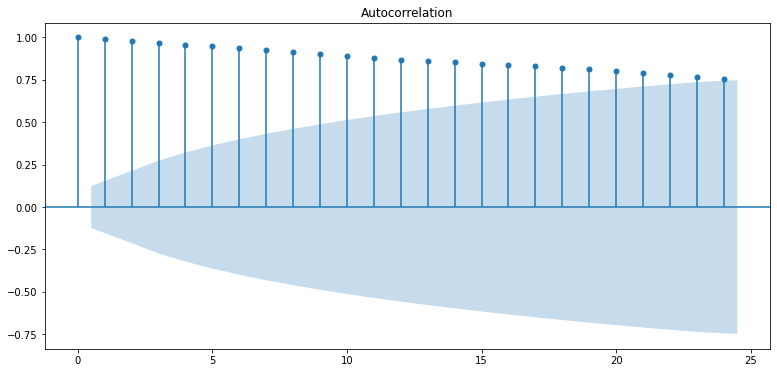

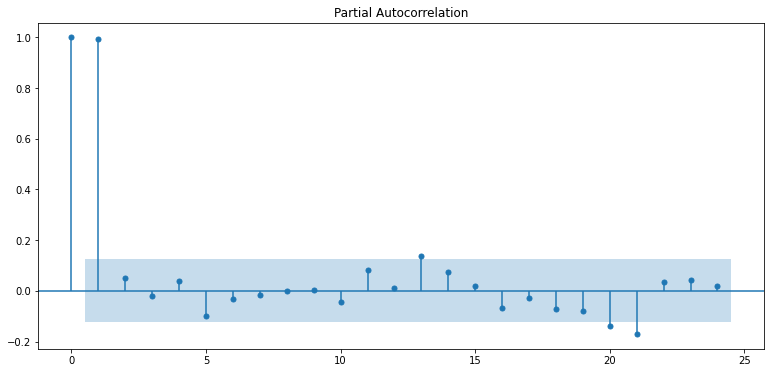

In [147]:
# international airline passengers 시계열의 statsmodel에서 제공하는 ACF와 PACF 플로팅 기능을 사용합니다.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log) # ACF: Autocorrelation 그래프 그리기
plot_pacf(ts_log) #PACF: Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 볼 때 p=1을 사용하는 것이 적합해 보입니다.. p=>2 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터를 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.  
반면 ACF는 점차적으로 감소하고 있습니다.  
q에 대해서는 적합한 값이 없어 보입니다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있지만 q를 바꿔 가면서 확인해 보는 것도 좋습니다.

d를 구하기 위해서는 d차 차분을 구해 보고 이 때 시계열이 안정된 상태인지를 확인해 보아야 합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


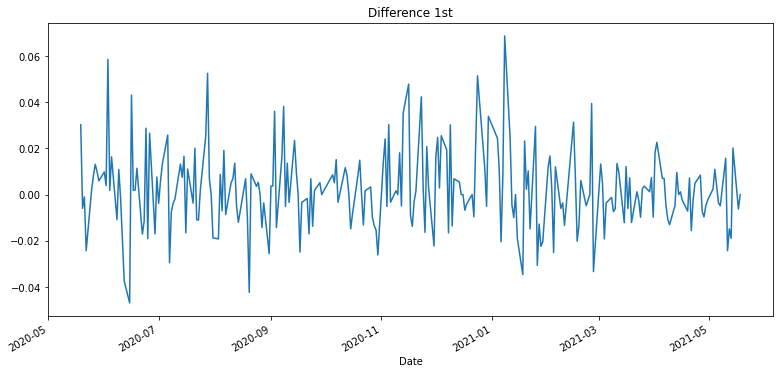

In [148]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


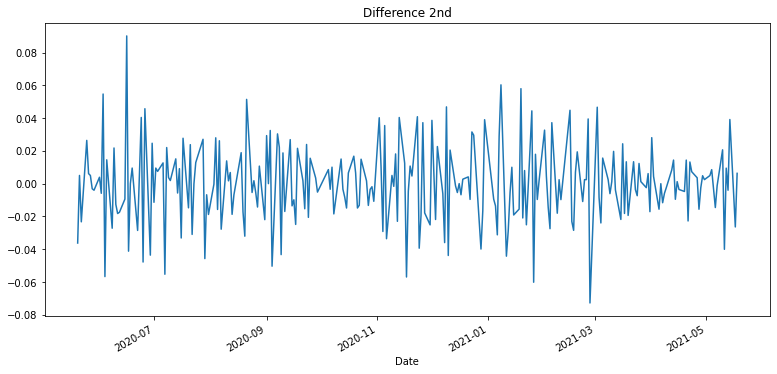

In [149]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분의 p-value가 더 낮기 때문에 d의 값은 0 또는 1로 하겠습니다.

## STEP 6 : ARIMA 모델 훈련과 테스트
위에서 p=1, d= 0 또는 1, q=0 으로 모수를 정하기로 했습니다. 이를 바탕으로 학습을 진행해 보겠습니다.

In [150]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 05 Sep 2021   AIC                          -1164.792
Time:                        10:25:20   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

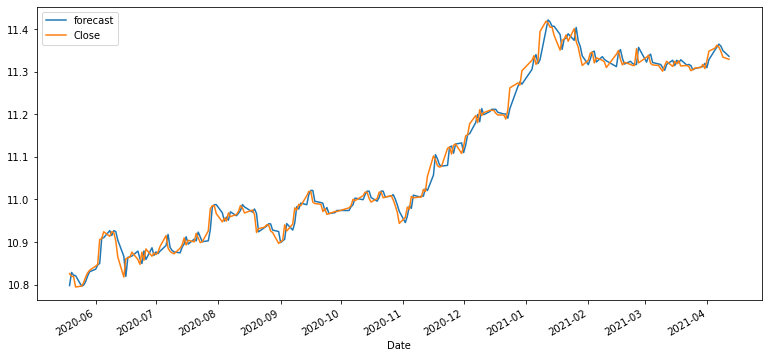

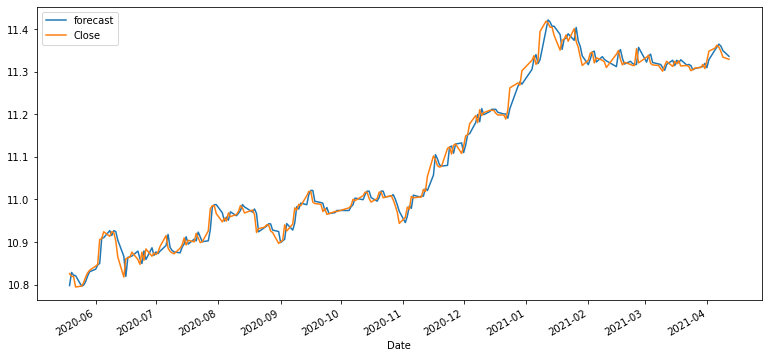

In [151]:
# 모델 훈련 결과 시각화
fitted_m.plot_predict()

forecast() 메소드를 이용해 테스트 데이터 구간을 예측해봅니다.

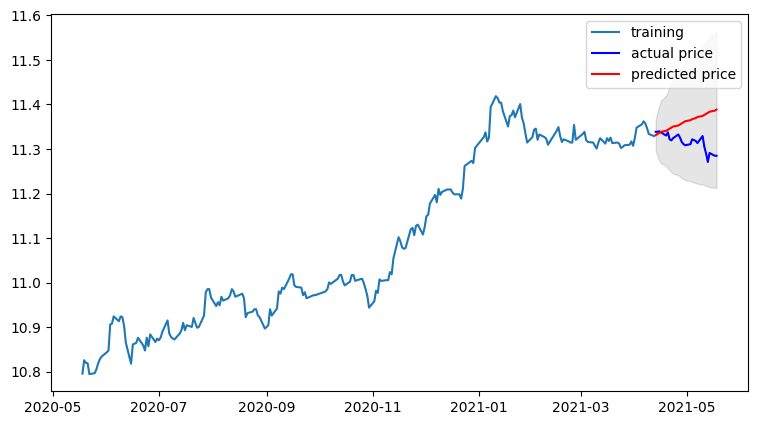

In [153]:
# Forecast L 결과가 fc에 담깁니다.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf

# 판다스 series를 만들어줍니다.
fc_series = pd.Series(fc, index=test_data.index) # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index) # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index) # 예측결과의 상한 바운드

# 시각화
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있습니다. np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산합니다.

In [155]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE :', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPEL {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE : 4699.719792301976
MAPEL 4.68%


### p=1, d=0, q = 0

In [158]:
model = ARIMA(train_data, order=(1, 0, 0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  225
Model:                     ARMA(1, 0)   Log Likelihood                 583.467
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 05 Sep 2021   AIC                          -1160.933
Time:                        10:35:53   BIC                          -1150.685
Sample:                             0   HQIC                         -1156.797
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.0688      0.210     52.701      0.000      10.657      11.480
ar.L1.Close     0.9972      0.003    298.854      0.000       0.991       1.004
                                    Roots       

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

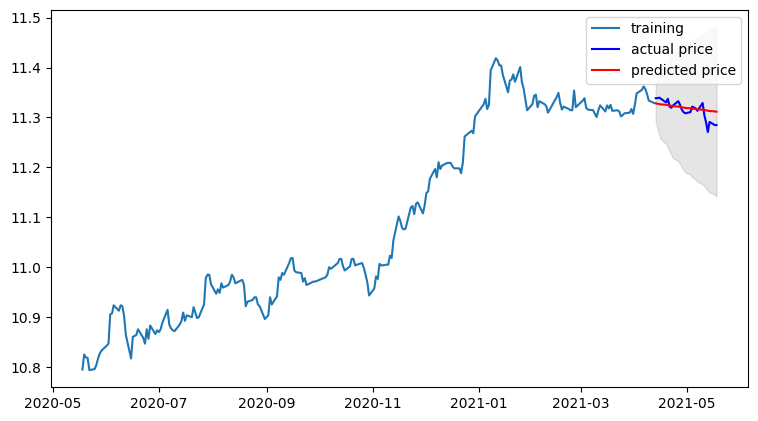

In [159]:
# Forecast L 결과가 fc에 담깁니다.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf

# 판다스 series를 만들어줍니다.
fc_series = pd.Series(fc, index=test_data.index) # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index) # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index) # 예측결과의 상한 바운드

# 시각화
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [160]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE :', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPEL {:.2f}%'.format(mape*100))

MSE:  1533430.4832786121
MAE:  957.802482046241
RMSE : 1238.3176019416878
MAPEL 1.18%


차분d(differencing)이 1일 때 보다 0일 때의 MSE, MAE, RMSE 수치가 더 적었습니다. 따라서 주어진 삼성전자 주가 예측 모델에는 d=0 모수를 사용하는 것이 적합한듯 합니다.

## STEP 7 : 다른 주식 종목 예측해 보기